In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, entropy

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, confusion_matrix

import pickle

np.random.seed(7)

### Data source

The data set was obtained from: https://www.kaggle.com/datasets/shubh0799/churn-modelling

### Data pre processing

#### Data access

In [2]:
data = pd.read_csv('Dados/Churn_Modelling.csv')
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
data.drop(columns={'RowNumber', 'CustomerId'}, inplace=True)

In [4]:
quantitative = ['CreditScore',
                'Age',
                'Tenure',
                'Balance',
                'NumOfProducts',
                'EstimatedSalary']

qualitative = []

for column in data.columns:
    if column not in quantitative:
        qualitative.append(column)

#### Data balance - undersampling negative cases

In [5]:
i = data.query('Exited == 0').index
i_sampled = np.random.choice(i, data.query('Exited == 1').shape[0])

data = pd.concat([data.loc[i_sampled], data.query('Exited == 1')], axis=0).sort_index()

#### Data vis - qualitative columns

In [6]:
for column in data.columns:
    if column not in quantitative:
        display(data[column].value_counts(normalize=True).to_frame())

,Surname
Smith,0.004173
McGregor,0.003927
Wright,0.003436
Chu,0.002946
Douglas,0.002946
...,...
Goodwin,0.000245
Landry,0.000245
Chinedum,0.000245
Cooke,0.000245


,Geography
France,0.463427
Germany,0.314188
Spain,0.222386


,Gender
Male,0.502209
Female,0.497791


,HasCrCard
1,0.704713
0,0.295287


,IsActiveMember
0,0.543692
1,0.456308


,Exited
0,0.5
1,0.5


#### Data vis - quantitative columns

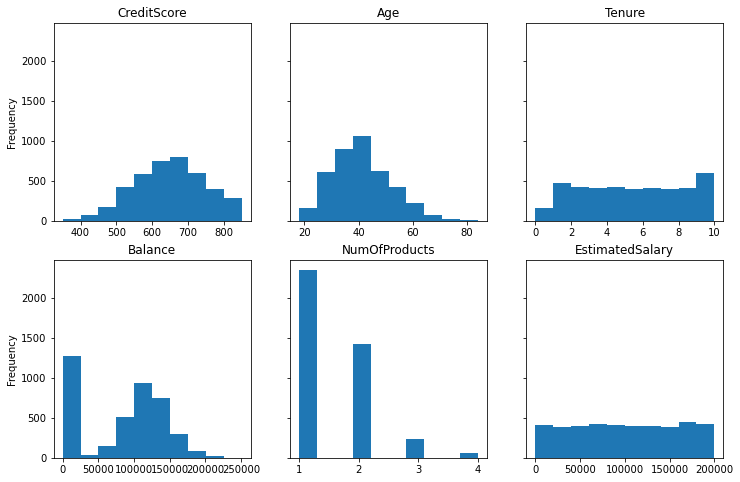

In [7]:
i = j = 0

fig, ax = plt.subplots(2, 3, sharey=True, figsize=(12,8))

for column in quantitative:
    ax[i][j].set_title(column)
    data[column].plot(kind='hist', ax=ax[i][j])
    j+=1

    if j%3==0:
        j=0
        i+=1

#### Feature engineering

In [8]:
surnames = data['Surname'].values

def func(x):
    """If a name appears more than one time in the surnames list, return 1, else, return 0"""
    aux = 0
    for name in surnames:
        if x == name:
            aux+=1
            
        if aux>1:
            return 1
            
    return 0

data['has_parents_costumer'] = data['Surname'].apply(func)

In [9]:
data['Geography_france'] = data['Geography'].apply(lambda x:1 if x == 'France' else 0)
data['Geography_germany'] = data['Geography'].apply(lambda x:1 if x == 'Germany' else 0)
data['Geography_spain'] = data['Geography'].apply(lambda x:1 if x == 'Spain' else 0)


data['Gender_female'] = data['Gender'].apply(lambda x:1 if x == 'Female' else 0)


data['Balance_0_10K'] = data['Balance'].apply(lambda x:1 if x<=10000 else 0)
data['Balance_10_100K'] = data['Balance'].apply(lambda x:1 if x>10000 and x<=100000 else 0)
data['Balance_100_130K'] = data['Balance'].apply(lambda x:1 if x>100000 and x<=130000 else 0)
data['Balance_130K_more'] = data['Balance'].apply(lambda x:1 if x>130000 else 0)


data = data[['CreditScore', 'Geography_france', 'Geography_germany',
             'Geography_spain', 'Gender_female', 'Age', 'Tenure',
             'Balance_0_10K', 'Balance_10_100K', 'Balance_100_130K', 'Balance_130K_more',
             'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
             'has_parents_costumer', 'EstimatedSalary', 'Exited']]

#### Outliers

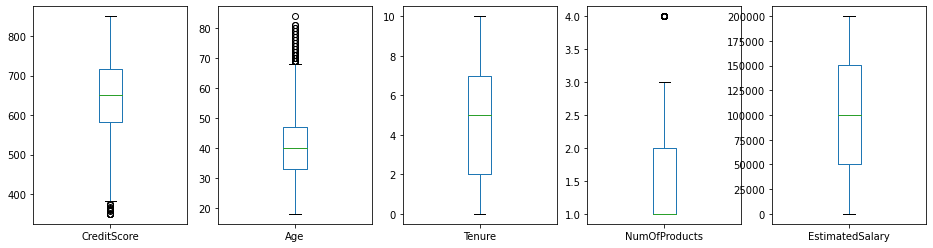

In [10]:
i = 0

fig, ax = plt.subplots(1, 5, figsize=(16,4))


for column in ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'EstimatedSalary']:
    data[column].plot(kind='box', ax=ax[i])
    i+=1

In [11]:
p1 = data.query('NumOfProducts == 3 or NumOfProducts == 4')['Exited'].sum() / data.query('NumOfProducts == 3 or NumOfProducts == 4')['Exited'].shape[0]
p2 = 1 - p1

entropy(pk=[p1, p2])

0.14999492361041492

Entropia juntando NumOfProducts == 3 e NumOfProducts == 4 manteve-se baixa

In [12]:
data['NumOfProducts'] = data['NumOfProducts'].apply(lambda x:3 if x == 4 else x)

In [13]:
floor = data['Age'].quantile(0.05)
roof = data['Age'].quantile(0.95)

data['Age'] = data['Age'].apply(lambda x:floor if x < floor else x)
data['Age'] = data['Age'].apply(lambda x:roof if x > roof else x)

In [14]:
median = data['CreditScore'].median()

q1 = data['CreditScore'].quantile(0.25)
q3 = data['CreditScore'].quantile(0.75)

IQR = q3-q1

# Outlier detection using IQR
data['CreditScore'] = data['CreditScore'].apply(lambda x:median if x < q1-1.2*IQR else x)
data['CreditScore'] = data['CreditScore'].apply(lambda x:median if x > q3+1.2*IQR else x)

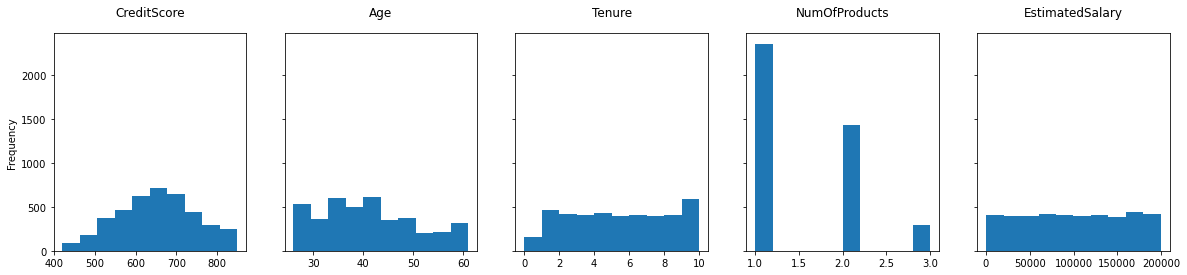

In [15]:
i = 0

fig, ax = plt.subplots(1, 5, figsize=(20,4), sharey=True)


for column in ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'EstimatedSalary']:
    ax[i].set_title(column, y=1.05)
    data[column].plot(kind='hist', ax=ax[i])
    i+=1

### Data processing

#### Gaussian Distribution analysis

In [16]:
for column in ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'EstimatedSalary']:
    p = shapiro(data[column])[1]
    if p > 0.05:
        print(f'{column} is Gaussian (p > 0.05): {p}')
    else:
        print(f'{column} is NOT Gaussian (p < 0.05): {p}')

CreditScore is NOT Gaussian (p < 0.05): 1.7323284056151508e-14
Age is NOT Gaussian (p < 0.05): 2.0419496205086632e-32
Tenure is NOT Gaussian (p < 0.05): 6.7868756246752e-36
NumOfProducts is NOT Gaussian (p < 0.05): 0.0
EstimatedSalary is NOT Gaussian (p < 0.05): 3.2505189936332817e-34


#### Data normalization

How the quantitative features haven't a gaussian distribution, this data will be normalized (with Min Max normalization) 

#### Data correlation in reference to the target variable

In [18]:
data.corr()['Exited'].sort_values().to_frame().drop('Exited', axis=0)

,Exited
IsActiveMember,-0.191700
Balance_0_10K,-0.141019
Geography_france,-0.131919
NumOfProducts,-0.075634
has_parents_costumer,-0.075085
Geography_spain,-0.047221
CreditScore,-0.029676
Balance_10_100K,-0.026816
HasCrCard,-0.012376
Tenure,-0.005264


- **Atividade e evasão são indiretamente proporcionais**: Clientes mais ativos acabam não saindo
- **Idade e evasão são diretamente proporcionais:** Clientes mais velhos acabam saindo

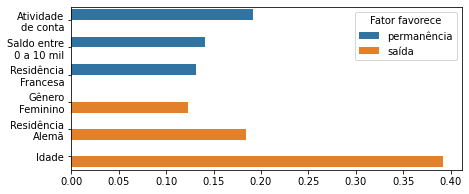

In [19]:
fig, ax = plt.subplots(figsize=(7, 3))

d1 = data.corr()['Exited'].sort_values().to_frame().drop('Exited', axis=0)[0:3].apply(lambda x:np.abs(x))

d2 = data.corr()['Exited'].sort_values().to_frame().drop('Exited', axis=0)[13:16]

d = pd.concat([d1, d2], axis=0)
d['Fator favorece'] = ['permanência', 'permanência', 'permanência', 'saída', 'saída', 'saída']

sns.barplot(y=d.index, x=d['Exited'], hue=d['Fator favorece'])

ax.set_yticklabels(['Atividade\nde conta',
            'Saldo entre\n 0 a 10 mil',
            'Residência\nFrancesa',
            'Gênero\nFeminino',
            'Residência\nAlemã',
            'Idade'])

ax.set_xlabel('')

plt.show()

C:\Users\vinip\.conda\envs\DataScience\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


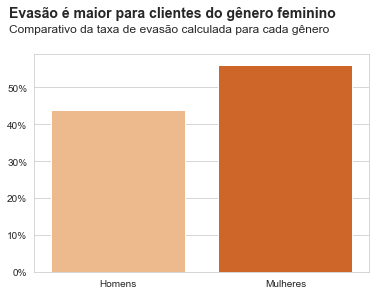

In [49]:
sns.set_style('whitegrid')

y = [data.query('Gender_female == 0')['Exited'].mean(),
     data.query('Gender_female == 1')['Exited'].mean()]

x = ['Homens', 'Mulheres']

ax = sns.barplot(x=x, y=y, palette='Oranges')

ax.text(s='Evasão é maior para clientes do gênero feminino', x=-0.65, y=0.69, weight='bold', fontsize=14)
ax.text(s='Comparativo da taxa de evasão calculada para cada gênero', x=-0.65, y=0.65, fontsize=12)
#ax.text(s='Idade em anos', x=-0.65, y=0.58, fontsize=10)
ax.set_xlabel('')
ax.set_xticklabels(x, rotation=0)
ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])

plt.savefig('Imagens/gen_exited_rate.jpeg', bbox_inches='tight')
plt.show()

C:\Users\vinip\.conda\envs\DataScience\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


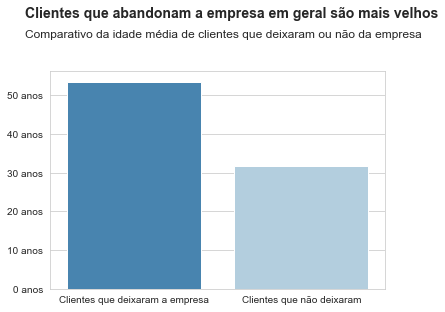

In [50]:
sns.set_style('whitegrid')

y = [data.query('Exited == 1')['Age'].mean(),
     data.query('Exited == 0')['Age'].mean()]

x = ['Clientes que deixaram a empresa', 'Clientes que não deixaram']

ax = sns.barplot(x=x, y=y, palette='Blues_r')

ax.text(s='Clientes que abandonam a empresa em geral são mais velhos', x=-0.65, y=0.70, weight='bold', fontsize=14)
ax.text(s='Comparativo da idade média de clientes que deixaram ou não da empresa', x=-0.65, y=0.65, fontsize=12)
ax.set_xlabel('')
ax.set_xticklabels(x, rotation=0)
ax.set_yticklabels(['0 anos', '10 anos', '20 anos', '30 anos', '40 anos', '50 anos'])

plt.savefig('Imagens/age_custumers.jpeg', bbox_inches='tight')
plt.show()

#### Data split

In [22]:
X = data.drop('Exited', axis=1)
y = data['Exited']

#### Modeling and evaluation

In [23]:
model = LogisticRegression(random_state=7)
kf = KFold(n_splits=6, shuffle=True, random_state=7)

accuracies_train = []
accuracies_test = []
cms = []
rocs = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)

    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracies_train.append(accuracy_train)
    
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    accuracies_test.append(accuracy_test)
    
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    rocs.append(roc)
    
    
accuracies_train = np.array(accuracies_train)    
accuracies_test = np.array(accuracies_test)
rocs = np.array(rocs)


print('Accuracy (train set): %.2f%% +- %.2f%%' % (accuracies_train.mean()*100, accuracies_train.std()*100))
print('Accuracy (test set): %.2f%% +- %.2f%%' % (accuracies_test.mean()*100, accuracies_test.std()*100))

print('\nRoc area under curve (test set): %.4f +- %.4f' % (rocs.mean(), rocs.std()))

Accuracy (train set): 71.49% +- 0.33%
Accuracy (test set): 71.28% +- 1.68%

Roc area under curve (test set): 0.7798 +- 0.0186


In [24]:
model = RandomForestClassifier(random_state=7, n_jobs=-1)
kf = KFold(n_splits=6, shuffle=True, random_state=7)

accuracies_train = []
accuracies_test = []
cms = []
rocs = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)

    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracies_train.append(accuracy_train)
    
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    accuracies_test.append(accuracy_test)
    
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    rocs.append(roc)
    
    
accuracies_train = np.array(accuracies_train)    
accuracies_test = np.array(accuracies_test)
rocs = np.array(rocs)


print('Accuracy (train set): %.2f%% +- %.2f%%' % (accuracies_train.mean()*100, accuracies_train.std()*100))
print('Accuracy (test set): %.2f%% +- %.2f%%' % (accuracies_test.mean()*100, accuracies_test.std()*100))

print('\nRoc area under curve (test set): %.4f +- %.4f' % (rocs.mean(), rocs.std()))

Accuracy (train set): 100.00% +- 0.00%
Accuracy (test set): 78.18% +- 1.51%

Roc area under curve (test set): 0.8693 +- 0.0186


#### Model dump

In [25]:
model.fit(X, y)

file = open('model.pk', 'wb')
pickle.dump(model, file)
file.close()

file = open('minmaxscaler.pk', 'wb')
pickle.dump(normalizer, file)
file.close()